# Molecular Oncology Almanac Assertion Analysis

MOA evidence items are referred to as assertions and MOA variants are referred to as features in this analysis. 

In [1]:
from enum import Enum
from typing import Dict
import json

import pandas as pd
import plotly.express as px
import requests
from ga4gh.core import sha512t24u


In [2]:
def get_feature_digest(feature: Dict) -> str:
    """Get digest for feature

    :param feature: MOA feature
    :return: Digest
    """
    attrs = json.dumps(
        feature["attributes"][0],
        sort_keys=True,
        separators=(",", ":"),
        indent=None
    ).encode("utf-8")
    return sha512t24u(attrs)

In [3]:
class VariantNormType(str, Enum):
    """Variation Normalization types"""

    NORMALIZED = "Normalized"
    NOT_SUPPORTED = "Not Supported"


VARIANT_NORM_TYPE_VALUES = [v.value for v in VariantNormType.__members__.values()]

In [4]:
class VariantCategory(str, Enum):
    """Create enum for the kind of variants that are in MOA."""

    EXPRESSION = "Expression"
    EPIGENETIC_MODIFICATION = "Epigenetic Modification"
    FUSION = "Fusion"
    PROTEIN_CONS = "Protein Consequence"
    GENE_FUNC = "Gene Function"
    REARRANGEMENTS = "Rearrangements"
    COPY_NUMBER = "Copy Number"
    OTHER = "Other"
    GENOTYPES_EASY = "Genotypes Easy"
    GENOTYPES_COMPOUND = "Genotypes Compound"
    REGION_DEFINED_VAR = "Region Defined Variant"
    TRANSCRIPT_VAR = "Transcript Variant"  # no attempt to normalize these ones, since there is no query we could use


VARIANT_CATEGORY_VALUES = [v.value for v in VariantCategory.__members__.values()]

## All Features (Variants) Analysis

### Creating a table with feature (variant) and assertion (evidence) information

In [5]:
# Create dictionary for MOA Feature ID -> Feature Type
r = requests.get("https://moalmanac.org/api/features")
if r.status_code == 200:
    feature_data = r.json()

features = {}

for feature in feature_data:
    feature_id = feature["feature_id"]
    digest = get_feature_digest(feature)
    features[digest] = feature["feature_type"]

count_unique_feature_ids = len(features.keys())
print(count_unique_feature_ids)


428


In [6]:
# Create DF for assertions and their associated feature + predictive implication
r = requests.get("https://moalmanac.org/api/assertions")
if r.status_code == 200:
    assertion_data = r.json()

transformed = []

# Mapping from feature ID to feature digest
feature_id_to_digest = {}

for assertion in assertion_data:
    assertion_id = assertion["assertion_id"]
    predictive_implication = assertion["predictive_implication"]

    if len(assertion["features"]) != 1:
        print(f"assertion id ({assertion_id}) does not have 1 feature")
        continue

    feature = assertion["features"][0]
    feature_id = feature["feature_id"]
    feature_digest = get_feature_digest(feature)

    feature_id_to_digest[feature_id] = digest

    transformed.append(
        {
            "assertion_id": assertion_id,
            "feature_id": feature_id,
            "feature_type": features[feature_digest],
            "predictive_implication": predictive_implication,
            "feature_digest": feature_digest
        }
    )
moa_df = pd.DataFrame(transformed)
moa_df

,assertion_id,feature_id,feature_type,predictive_implication,feature_digest
0,1,1,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP
1,2,2,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP
2,3,3,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP
3,4,4,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP
4,5,5,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP
...,...,...,...,...,...
889,890,890,somatic_variant,FDA-Approved,c3CkYcMt4ssh4AL4gpacJtFil8xl2TB2
890,891,891,somatic_variant,FDA-Approved,uAW4cOXId1N1MKo5fqHYdw9JGceCMmE5
891,892,892,somatic_variant,FDA-Approved,B5m8cSgi6w2xRCg0X_dPpQU2dwbvtXk1
892,893,893,somatic_variant,FDA-Approved,YLXf4Q8yr45bD0I_v6nkpDjBFuGPdFbd


In [7]:
unique_features_df = moa_df.sort_values("feature_id").drop_duplicates("feature_digest")
len_unique_feature_ids = len(list(unique_features_df.feature_id))

In [8]:
total_len_features = len(moa_df.feature_digest.unique())
f"Total number of unique features (variants): {total_len_features}"

'Total number of unique features (variants): 428'

In [9]:
assert total_len_features == len_unique_feature_ids

In [10]:
total_len_assertions = len(moa_df.assertion_id.unique())
f"Total number of unique assertions (evidence items): {total_len_assertions}"

'Total number of unique assertions (evidence items): 894'

### Converting feature (variant) types to normalized categories

In [11]:
list(moa_df.feature_type.unique())

['rearrangement',
 'somatic_variant',
 'germline_variant',
 'copy_number',
 'microsatellite_stability',
 'mutational_signature',
 'mutational_burden',
 'knockdown',
 'aneuploidy']

In [12]:
moa_df["category"] = moa_df["feature_type"].copy()

moa_df["category"] = moa_df["category"].replace("rearrangement", VariantCategory.REARRANGEMENTS.value)
moa_df["category"] = moa_df["category"].replace("aneuploidy", VariantCategory.COPY_NUMBER.value)
moa_df["category"] = moa_df["category"].replace("knockdown", VariantCategory.EXPRESSION.value)
moa_df["category"] = moa_df["category"].replace("somatic_variant", VariantCategory.PROTEIN_CONS.value)
moa_df["category"] = moa_df["category"].replace("germline_variant", VariantCategory.PROTEIN_CONS.value)
moa_df["category"] = moa_df["category"].replace("microsatellite_stability", VariantCategory.REARRANGEMENTS.value)
moa_df["category"] = moa_df["category"].replace("mutational_burden", VariantCategory.OTHER.value)
moa_df["category"] = moa_df["category"].replace("mutational_signature", VariantCategory.OTHER.value)
moa_df["category"] = moa_df["category"].replace("copy_number", VariantCategory.COPY_NUMBER.value)

moa_df.head()

,assertion_id,feature_id,feature_type,predictive_implication,feature_digest,category
0,1,1,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements
1,2,2,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements
2,3,3,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements
3,4,4,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements
4,5,5,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements


In [13]:
list(moa_df.category.unique())

['Rearrangements', 'Protein Consequence', 'Copy Number', 'Other', 'Expression']

### Adding a numerical impact score based on the predictive implication
This is based on the structure of MOA scoring

In [14]:
predictive_implication_categories = moa_df.predictive_implication.unique()
list(predictive_implication_categories)

['FDA-Approved',
 'Guideline',
 'Clinical trial',
 'Preclinical',
 'Inferential',
 'Clinical evidence']

In [15]:
moa_df["impact_score"] = moa_df["predictive_implication"].copy()

moa_df.loc[moa_df["impact_score"] == "FDA-Approved", "impact_score"] = 10
moa_df.loc[moa_df["impact_score"] == "Guideline", "impact_score"] = 10
moa_df.loc[moa_df["impact_score"] == "Clinical evidence", "impact_score"] = 5
moa_df.loc[moa_df["impact_score"] == "Clinical trial", "impact_score"] = 5
moa_df.loc[moa_df["impact_score"] == "Preclinical", "impact_score"] = 1
moa_df.loc[moa_df["impact_score"] == "Inferential", "impact_score"] = 1

moa_df.head()

,assertion_id,feature_id,feature_type,predictive_implication,feature_digest,category,impact_score
0,1,1,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements,10
1,2,2,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements,10
2,3,3,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements,10
3,4,4,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements,10
4,5,5,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements,10


### Impact Score Analysis

In [16]:
feature_categories_impact_data = dict()
for category in VARIANT_CATEGORY_VALUES:
    feature_categories_impact_data[category] = {}
    impact_category_df = moa_df[moa_df.category == category]

    total_sum_category_impact = impact_category_df["impact_score"].sum()
    feature_categories_impact_data[category]["total_sum_category_impact"] = total_sum_category_impact
    print(f"{category}: {total_sum_category_impact}")

Expression: 12
Epigenetic Modification: 0
Fusion: 0
Protein Consequence: 4199
Gene Function: 0
Rearrangements: 644
Copy Number: 415
Other: 62
Genotypes Easy: 0
Genotypes Compound: 0
Region Defined Variant: 0
Transcript Variant: 0


### Features (Variants) Analysis

In [17]:
moa_feature_data = dict()
for category in VARIANT_CATEGORY_VALUES:
    moa_feature_data[category] = {}
    feature_type_df = moa_df[moa_df.category == category]

    number_unique_category_features = len(set(feature_type_df.feature_digest))
    moa_feature_data[category]["number_unique_category_features"] = number_unique_category_features

    fraction_category_feature = f"{number_unique_category_features} / {total_len_features}"
    moa_feature_data[category]["fraction_category_feature"] = fraction_category_feature

    percent_category_feature = "{:.2f}".format(number_unique_category_features / total_len_features * 100) + "%"
    moa_feature_data[category]["percent_category_feature"] = percent_category_feature

### Assertions (Evidence Items) Analysis

In [18]:
moa_assertion_data = dict()
for category in VARIANT_CATEGORY_VALUES:
    moa_assertion_data[category] = {}
    assertion_type_df = moa_df[moa_df.category == category]

    number_unique_category_assertions = len(set(assertion_type_df.assertion_id))
    moa_assertion_data[category]["number_unique_category_assertions"] = number_unique_category_assertions

    fraction_category_assertion = f"{number_unique_category_assertions} / {total_len_assertions}"
    moa_assertion_data[category]["fraction_category_assertion"] = fraction_category_assertion

    percent_category_assertion = "{:.2f}".format(number_unique_category_assertions / total_len_assertions * 100) + "%"
    moa_assertion_data[category]["percent_category_assertion"] = percent_category_assertion

### Summaries for all Features (Variants) and Assertions (Evidence Items)

In [19]:
feature_category_impact_score = [v["total_sum_category_impact"] for v in feature_categories_impact_data.values()]
feature_category_number = [v["number_unique_category_features"] for v in moa_feature_data.values()]
feature_category_fraction = [v["fraction_category_feature"] for v in moa_feature_data.values()]
feature_category_percent = [v["percent_category_feature"] for v in moa_feature_data.values()]
feature_category_assertion_number = [v["number_unique_category_assertions"] for v in moa_assertion_data.values()]
feature_category_assertion_fraction = [v["fraction_category_assertion"] for v in moa_assertion_data.values()]
feature_category_assertion_percent = [v["percent_category_assertion"] for v in moa_assertion_data.values()]

In [20]:
feature_category_dict = {
    "Category": VARIANT_CATEGORY_VALUES,
    "Number of Features": feature_category_number,
    "Fraction of Features": feature_category_fraction,
    "Percent of Features": feature_category_percent,
    "Number of Assertions": feature_category_assertion_number,
    "Fraction of Assertions": feature_category_assertion_fraction,
    "Percent of Assertions": feature_category_assertion_percent,
    "Impact Score": feature_category_impact_score
}

In [21]:
moa_feature_df = pd.DataFrame(feature_category_dict)
moa_feature_df

,Category,Number of Features,Fraction of Features,Percent of Features,Number of Assertions,Fraction of Assertions,Percent of Assertions,Impact Score
0,Expression,11,11 / 428,2.57%,12,12 / 894,1.34%,12
1,Epigenetic Modification,0,0 / 428,0.00%,0,0 / 894,0.00%,0
2,Fusion,0,0 / 428,0.00%,0,0 / 894,0.00%,0
3,Protein Consequence,323,323 / 428,75.47%,676,676 / 894,75.62%,4199
4,Gene Function,0,0 / 428,0.00%,0,0 / 894,0.00%,0
5,Rearrangements,38,38 / 428,8.88%,81,81 / 894,9.06%,644
6,Copy Number,47,47 / 428,10.98%,102,102 / 894,11.41%,415
7,Other,9,9 / 428,2.10%,23,23 / 894,2.57%,62
8,Genotypes Easy,0,0 / 428,0.00%,0,0 / 894,0.00%,0
9,Genotypes Compound,0,0 / 428,0.00%,0,0 / 894,0.00%,0


In [22]:
moa_feature_df["Percent of Features"] = moa_feature_df["Fraction of Features"].astype(str) + " (" + moa_feature_df["Percent of Features"] + ")"
moa_feature_df["Percent of Assertions"] = moa_feature_df["Fraction of Assertions"].astype(str) + " (" + moa_feature_df["Percent of Assertions"] + ")"

In [23]:
moa_feature_df_abbreviated = moa_feature_df.drop(["Number of Features", "Fraction of Features", "Number of Assertions", "Fraction of Assertions"], axis=1)

In [24]:
moa_feature_df_abbreviated = moa_feature_df_abbreviated.set_index("Category")
moa_feature_df_abbreviated

,Percent of Features,Percent of Assertions,Impact Score
Category,,,
Expression,11 / 428 (2.57%),12 / 894 (1.34%),12
Epigenetic Modification,0 / 428 (0.00%),0 / 894 (0.00%),0
Fusion,0 / 428 (0.00%),0 / 894 (0.00%),0
Protein Consequence,323 / 428 (75.47%),676 / 894 (75.62%),4199
Gene Function,0 / 428 (0.00%),0 / 894 (0.00%),0
Rearrangements,38 / 428 (8.88%),81 / 894 (9.06%),644
Copy Number,47 / 428 (10.98%),102 / 894 (11.41%),415
Other,9 / 428 (2.10%),23 / 894 (2.57%),62
Genotypes Easy,0 / 428 (0.00%),0 / 894 (0.00%),0


In [25]:
fig = px.scatter(
    data_frame=moa_feature_df,
    x="Number of Assertions",
    y="Impact Score",
    size="Number of Features",
    size_max=40,
    text="Number of Features",
    color="Category"
)
fig.show()

In [26]:
fig.write_html("moa_feature_categories_impact_scatterplot.html")

## Create functions / global variables used in analysis

In [27]:
feature_analysis_summary = {
    "Variant Category": VARIANT_NORM_TYPE_VALUES,
    "Count of MOA Features per Category":[],
    "Fraction of all MOA Features": [],
    "Percentage of all MOA Features": []
}
feature_analysis_summary

{'Variant Category': ['Normalized', 'Not Supported'],
 'Count of MOA Features per Category': [],
 'Fraction of all MOA Features': [],
 'Percentage of all MOA Features': []}

In [28]:
def feature_analysis(df: pd.DataFrame, variant_norm_type: VariantNormType) -> pd.DataFrame:
    """Do feature analysis (counts, percentages). Updates `feature_analysis_summary`

    :param df: Dataframe of variants
    :param variant_norm_type: The kind of features that are in `df`
    :return: Transformed dataframe with variant ID duplicates dropped
    """
    # Drop duplicate rows
    df = df.drop_duplicates(subset=["feature_id"])
    feature_ids = list(df["feature_id"])

    # Count
    num_features = len(feature_ids)
    fraction_features = f"{num_features} / {total_len_features}"
    print(f"\nNumber of {variant_norm_type.value} Features in MOA: {fraction_features}")

    # Percentage
    percentage_features = f"{num_features / total_len_features * 100:.2f}%"
    print(f"Percentage of {variant_norm_type.value} Features in MOA: {percentage_features}")

    feature_analysis_summary["Count of MOA Features per Category"].append(num_features)
    feature_analysis_summary["Fraction of all MOA Features"].append(fraction_features)
    feature_analysis_summary["Percentage of all MOA Features"].append(percentage_features)

    return df

In [29]:
assertion_analysis_summary = {
    "Variant Category": VARIANT_NORM_TYPE_VALUES,
    "Count of MOA Assertions per Category":[],
    "Fraction of all MOA Assertions": [],
    "Percentage of all MOA Assertions": []
}
assertion_analysis_summary

{'Variant Category': ['Normalized', 'Not Supported'],
 'Count of MOA Assertions per Category': [],
 'Fraction of all MOA Assertions': [],
 'Percentage of all MOA Assertions': []}

In [30]:
def assertion_analysis(all_df: pd.DataFrame, variant_norm_df: pd.DataFrame, variant_norm_type: VariantNormType):
    """Do evidence analysis (counts, percentages). Updates `assertion_analysis_summary`

    :param all_df: Dataframe for all assertions and features
    :param variant_norm_df: Dataframe for features given certain `variant_norm_type`
    :param variant_norm_type: The kind of variants that are in `df`
    """
    # Need to do this bc of duplicate features
    _feature_ids = set(variant_norm_df.feature_digest)
    tmp_df = all_df[all_df["feature_digest"].isin(_feature_ids)]
    
    # Count
    num_assertions = len(tmp_df.assertion_id)
    fraction_assertions = f"{num_assertions} / {total_len_assertions}"
    print(f"Number of {variant_norm_type.value} Feature Assertions in MOA: {fraction_assertions}")

    # Percentage
    percentage_assertions = f"{num_assertions / total_len_assertions * 100:.2f}%"
    print(f"Percentage of {variant_norm_type.value} Feature Assertions in MOA: {percentage_assertions}")

    assertion_analysis_summary["Count of MOA Assertions per Category"].append(num_assertions)
    assertion_analysis_summary["Fraction of all MOA Assertions"].append(fraction_assertions)
    assertion_analysis_summary["Percentage of all MOA Assertions"].append(percentage_assertions)

In [31]:
feature_id_to_digest_df = pd.DataFrame(feature_id_to_digest.items(), columns=["feature_id", "feature_digest"])
feature_id_to_digest_df

,feature_id,feature_digest
0,1,B5m8cSgi6w2xRCg0X_dPpQU2dwbvtXk1
1,2,B5m8cSgi6w2xRCg0X_dPpQU2dwbvtXk1
2,3,B5m8cSgi6w2xRCg0X_dPpQU2dwbvtXk1
3,4,B5m8cSgi6w2xRCg0X_dPpQU2dwbvtXk1
4,5,B5m8cSgi6w2xRCg0X_dPpQU2dwbvtXk1
...,...,...
889,890,B5m8cSgi6w2xRCg0X_dPpQU2dwbvtXk1
890,891,B5m8cSgi6w2xRCg0X_dPpQU2dwbvtXk1
891,892,B5m8cSgi6w2xRCg0X_dPpQU2dwbvtXk1
892,893,B5m8cSgi6w2xRCg0X_dPpQU2dwbvtXk1


## Normalized Analysis

In [32]:
normalized_queries_df = pd.read_csv("able_to_normalize_queries.csv", sep="\t")
normalized_queries_df = pd.merge(normalized_queries_df, feature_id_to_digest_df, left_on="variant_id", right_on="feature_id")
normalized_queries_df.shape

(179, 7)

In [33]:
normalized_queries_df = pd.merge(normalized_queries_df["variant_id"], moa_df, left_on="variant_id", right_on="feature_id", how="left")
normalized_queries_df = normalized_queries_df.drop(columns=["variant_id"])

In [34]:
normalized_queries_df = feature_analysis(normalized_queries_df, VariantNormType.NORMALIZED)
normalized_queries_df



Number of Normalized Features in MOA: 179 / 428
Percentage of Normalized Features in MOA: 41.82%


,assertion_id,feature_id,feature_type,predictive_implication,feature_digest,category,impact_score
0,71,71,somatic_variant,Preclinical,KgolzM3HWhww4t4HywFYCySUtGRIQ_mx,Protein Consequence,1
1,73,73,somatic_variant,Clinical evidence,j3HtSnIdrU8CcuW8_Qs3qVxOn-kMJV1T,Protein Consequence,5
2,75,75,somatic_variant,Clinical evidence,X_Az48pPjt4IODuY2a50Yl2_1tGopcuF,Protein Consequence,5
3,76,76,somatic_variant,Clinical evidence,LQQXFXpA4FCOQ3Fz4988x2vynER4J-Wh,Protein Consequence,5
4,77,77,somatic_variant,Clinical evidence,DKoCqZUY0WBdUnoly9DL_PAjBBZTs51d,Protein Consequence,5
...,...,...,...,...,...,...,...
174,858,858,copy_number,Clinical evidence,UYE-1dofAcf0kc44xdOY2hxwkMNUzjl7,Copy Number,5
175,859,859,copy_number,Inferential,s8SpNzXJuTJlGEqC0Rk-zd8ke9l4fq00,Copy Number,1
176,868,868,somatic_variant,FDA-Approved,xEngbInsi1BKQp2pVFi44N8CYLj6ZEkD,Protein Consequence,10
177,869,869,somatic_variant,FDA-Approved,fqvuveTjuO96HizOsbWgFQmfF76lGtdl,Protein Consequence,10


In [35]:
assertion_analysis(moa_df, normalized_queries_df, VariantNormType.NORMALIZED)

Number of Normalized Feature Assertions in MOA: 325 / 894
Percentage of Normalized Feature Assertions in MOA: 36.35%


## Not Supported Analysis

In [36]:
not_supported_queries_df = pd.read_csv("not_supported_variants.csv", sep="\t")
not_supported_queries_df = pd.merge(not_supported_queries_df, feature_id_to_digest_df, left_on="variant_id", right_on="feature_id")
not_supported_queries_df.shape

(244, 6)

In [37]:
not_supported_queries_df = pd.merge(not_supported_queries_df["variant_id"], moa_df, left_on="variant_id", right_on="feature_id", how="left")
not_supported_queries_df = not_supported_queries_df.drop(columns=["variant_id"])
not_supported_queries_df

,assertion_id,feature_id,feature_type,predictive_implication,feature_digest,category,impact_score
0,1,1,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements,10
1,12,12,rearrangement,FDA-Approved,g99yF3kKnB-We_fMS5RaVygoSuT7qA-I,Rearrangements,10
2,15,15,rearrangement,FDA-Approved,e8PMq2A96-aBJ3Ip74ovx5VOUCztBTq7,Rearrangements,10
3,18,18,rearrangement,Guideline,DxfRiRV-3J6zRON4pnzNJjXkJf2bsp20,Rearrangements,10
4,21,21,rearrangement,Preclinical,BRsPjsZSCyDXnKtBt9XgsWX2JDNWY3FP,Rearrangements,1
...,...,...,...,...,...,...,...
239,849,849,copy_number,Inferential,jLD_tOKaW8wX5P2RiZ7EkMT8yBzfA_U_,Copy Number,1
240,853,853,copy_number,Inferential,3ZPmhQucEgPWkaRLg9viECM4O4pEg-BU,Copy Number,1
241,862,862,copy_number,Preclinical,LwEU_0YQA4iVchOdEiBrq_RmIciU-9EW,Copy Number,1
242,863,863,rearrangement,FDA-Approved,MpJsmn4LCLMXDsTNTTlyV5t3fKAnsJzL,Rearrangements,10


### Feature (Variant) Analysis

In [38]:
not_supported_queries_df = feature_analysis(not_supported_queries_df, VariantNormType.NOT_SUPPORTED)


Number of Not Supported Features in MOA: 244 / 428
Percentage of Not Supported Features in MOA: 57.01%


### Not Supported Feature (Variant) Analysis by Subcategory

In [39]:
not_supported_feature_analysis_summary = {
    "Category": VARIANT_CATEGORY_VALUES,
    "Count of MOA Features per Category":[],
    "Fraction of all MOA Features": [],
    "Percent of all MOA Features": [],
    "Fraction of Not Supported Features": [],
    "Percent of Not Supported Features": [],
}

In [40]:
not_supported_feature_categories_summary_data = dict()
total_number_unique_not_supported_features = len(set(not_supported_queries_df.feature_id))

for category in VARIANT_CATEGORY_VALUES:  # These are not supported categories
    not_supported_feature_categories_summary_data[category] = {}
    category_df = not_supported_queries_df[not_supported_queries_df.category == category]

    # Count
    number_unique_not_supported_category_features = len(set(category_df.feature_id))
    not_supported_feature_categories_summary_data[category]["number_unique_not_supported_category_features"] = number_unique_not_supported_category_features

    # Fraction
    fraction_not_supported_category_feature_of_moa = f"{number_unique_not_supported_category_features} / {total_len_features}"
    not_supported_feature_categories_summary_data[category]["fraction_not_supported_category_feature_of_moa"] = fraction_not_supported_category_feature_of_moa

    # Percent
    percent_not_supported_category_feature_of_moa = f"{number_unique_not_supported_category_features / total_len_features * 100:.2f}%"
    not_supported_feature_categories_summary_data[category]["percent_not_supported_category_feature_of_moa"] = percent_not_supported_category_feature_of_moa

    # Not supported fraction
    fraction_not_supported_category_feature_of_total_not_supported = f"{number_unique_not_supported_category_features} / {total_number_unique_not_supported_features}"
    not_supported_feature_categories_summary_data[category]["fraction_not_supported_category_feature_of_total_not_supported"] = fraction_not_supported_category_feature_of_total_not_supported

    # Not supported percent
    percent_not_supported_category_feature_of_total_not_supported = f"{number_unique_not_supported_category_features / total_number_unique_not_supported_features * 100:.2f}%"
    not_supported_feature_categories_summary_data[category]["percent_not_supported_category_feature_of_total_not_supported"] = percent_not_supported_category_feature_of_total_not_supported

    not_supported_feature_analysis_summary["Count of MOA Features per Category"].append(number_unique_not_supported_category_features)
    not_supported_feature_analysis_summary["Fraction of all MOA Features"].append(fraction_not_supported_category_feature_of_moa)
    not_supported_feature_analysis_summary["Percent of all MOA Features"].append(percent_not_supported_category_feature_of_moa)
    not_supported_feature_analysis_summary["Fraction of Not Supported Features"].append(fraction_not_supported_category_feature_of_total_not_supported)
    not_supported_feature_analysis_summary["Percent of Not Supported Features"].append(percent_not_supported_category_feature_of_total_not_supported)

In [41]:
number_unique_not_supported_category_features

0

In [42]:
not_supported_variant_df = pd.DataFrame(not_supported_feature_analysis_summary)
not_supported_variant_df

,Category,Count of MOA Features per Category,Fraction of all MOA Features,Percent of all MOA Features,Fraction of Not Supported Features,Percent of Not Supported Features
0,Expression,11,11 / 428,2.57%,11 / 244,4.51%
1,Epigenetic Modification,0,0 / 428,0.00%,0 / 244,0.00%
2,Fusion,0,0 / 428,0.00%,0 / 244,0.00%
3,Protein Consequence,169,169 / 428,39.49%,169 / 244,69.26%
4,Gene Function,0,0 / 428,0.00%,0 / 244,0.00%
5,Rearrangements,38,38 / 428,8.88%,38 / 244,15.57%
6,Copy Number,17,17 / 428,3.97%,17 / 244,6.97%
7,Other,9,9 / 428,2.10%,9 / 244,3.69%
8,Genotypes Easy,0,0 / 428,0.00%,0 / 244,0.00%
9,Genotypes Compound,0,0 / 428,0.00%,0 / 244,0.00%


### Not Support Feature (Variant) Assertion (Evidence) Analysis by Subcategory

List all the possible variant categories

In [43]:
not_supported_feature_categories = not_supported_queries_df.category.unique()
[v for v in not_supported_feature_categories]

['Rearrangements', 'Protein Consequence', 'Copy Number', 'Other', 'Expression']

In [44]:
not_supported_queries_df

,assertion_id,feature_id,feature_type,predictive_implication,feature_digest,category,impact_score
0,1,1,rearrangement,FDA-Approved,RnRyn89cJzVbVM93aw4OA44NIF5zblyP,Rearrangements,10
1,12,12,rearrangement,FDA-Approved,g99yF3kKnB-We_fMS5RaVygoSuT7qA-I,Rearrangements,10
2,15,15,rearrangement,FDA-Approved,e8PMq2A96-aBJ3Ip74ovx5VOUCztBTq7,Rearrangements,10
3,18,18,rearrangement,Guideline,DxfRiRV-3J6zRON4pnzNJjXkJf2bsp20,Rearrangements,10
4,21,21,rearrangement,Preclinical,BRsPjsZSCyDXnKtBt9XgsWX2JDNWY3FP,Rearrangements,1
...,...,...,...,...,...,...,...
239,849,849,copy_number,Inferential,jLD_tOKaW8wX5P2RiZ7EkMT8yBzfA_U_,Copy Number,1
240,853,853,copy_number,Inferential,3ZPmhQucEgPWkaRLg9viECM4O4pEg-BU,Copy Number,1
241,862,862,copy_number,Preclinical,LwEU_0YQA4iVchOdEiBrq_RmIciU-9EW,Copy Number,1
242,863,863,rearrangement,FDA-Approved,MpJsmn4LCLMXDsTNTTlyV5t3fKAnsJzL,Rearrangements,10


In [45]:
assertion_analysis(moa_df, not_supported_queries_df, VariantNormType.NOT_SUPPORTED)


Number of Not Supported Feature Assertions in MOA: 564 / 894
Percentage of Not Supported Feature Assertions in MOA: 63.09%


In [46]:
not_supported_feature_assertion_summary = {
    "Category": VARIANT_CATEGORY_VALUES,
    "Count of MOA Assertions per Category": [],
    "Fraction of MOA Assertions": [],
    "Percent of all MOA Assertions": [],
    "Fraction of Not Supported Feature Assertions": [],
    "Percent of Not Supported Feature Assertions": []
}

In [47]:
not_supported_feature_ids = set(not_supported_queries_df.feature_digest)

In [48]:
not_supported_feature_categories_assertion_summary_data = dict()
total_number_not_supported_feature_unique_assertions = len(set(not_supported_queries_df.assertion_id))
not_supported_feature_ids = set(not_supported_queries_df.feature_digest)

for category in VARIANT_CATEGORY_VALUES:    
    not_supported_feature_categories_assertion_summary_data[category] = {}

    # Need to do this bc of duplicate features
    tmp_df = moa_df[moa_df["feature_digest"].isin(not_supported_feature_ids)]
    
    evidence_category_df = tmp_df[tmp_df.category == category]
    
    evidence_category_df = evidence_category_df.drop_duplicates(subset=["assertion_id"])

    # Count
    number_unique_not_supported_category_assertion = len(set(evidence_category_df.assertion_id))
    not_supported_feature_categories_assertion_summary_data[category]["number_unique_not_supported_category_assertion"] = number_unique_not_supported_category_assertion

    # Fraction
    fraction_not_supported_category_feature_assertion_of_moa = f"{number_unique_not_supported_category_assertion} / {total_len_assertions}"
    not_supported_feature_categories_assertion_summary_data[category]["fraction_not_supported_category_feature_assertion_of_moa"] = fraction_not_supported_category_feature_assertion_of_moa

    # Percent
    percent_not_supported_category_feature_assertion_of_moa = f"{number_unique_not_supported_category_assertion / total_len_assertions * 100:.2f}%"
    not_supported_feature_categories_assertion_summary_data[category]["percent_not_supported_category_feature_assertion_of_moa"] = percent_not_supported_category_feature_assertion_of_moa

    # Not supported fraction
    fraction_not_supported_category_feature_assertion_of_total_not_supported = f"{number_unique_not_supported_category_assertion} / {total_number_not_supported_feature_unique_assertions}"
    not_supported_feature_categories_assertion_summary_data[category]["fraction_not_supported_category_feature_assertion_of_total_not_supported"] = fraction_not_supported_category_feature_assertion_of_total_not_supported

    # Not supported percent
    percent_not_supported_category_feature_assertion_of_total_not_supported = f"{number_unique_not_supported_category_assertion / total_number_not_supported_feature_unique_assertions * 100:.2f}%"
    not_supported_feature_categories_assertion_summary_data[category]["percent_not_supported_category_feature_assertion_of_total_not_supported"] = percent_not_supported_category_feature_assertion_of_total_not_supported


    not_supported_feature_assertion_summary["Count of MOA Assertions per Category"].append(number_unique_not_supported_category_assertion)
    not_supported_feature_assertion_summary["Fraction of MOA Assertions"].append(fraction_not_supported_category_feature_assertion_of_moa)
    not_supported_feature_assertion_summary["Percent of all MOA Assertions"].append(percent_not_supported_category_feature_assertion_of_moa)
    not_supported_feature_assertion_summary["Fraction of Not Supported Feature Assertions"].append(fraction_not_supported_category_feature_assertion_of_total_not_supported)
    not_supported_feature_assertion_summary["Percent of Not Supported Feature Assertions"].append(percent_not_supported_category_feature_assertion_of_total_not_supported)


In [49]:
number_unique_not_supported_category_features

0

## Impact by Subcategory

In [50]:
not_supported_impact_summary = {
    "Category": VARIANT_CATEGORY_VALUES,
    "MOA Total Sum Impact Score": [],
    'Average Impact Score per Feature': [],
    'Average Impact Score per Assertion':[],
    "Total Number Assertions": [v["number_unique_not_supported_category_assertion"] for v in not_supported_feature_categories_assertion_summary_data.values()],
    "Total Number Features": [v["number_unique_not_supported_category_features"] for v in not_supported_feature_categories_summary_data.values()]
}

In [51]:
not_supported_feature_categories_impact_data = dict()
for category in VARIANT_CATEGORY_VALUES:
    #print(category)
    not_supported_feature_categories_impact_data[category] = {}
    impact_category_df = not_supported_queries_df[not_supported_queries_df["category"] == category].copy()

    total_sum_not_supported_category_impact = impact_category_df["impact_score"].sum()
    #print(f"total sum {total_sum_not_supported_category_impact}")
    not_supported_feature_categories_impact_data[category]["total_sum_not_supported_category_impact"] = total_sum_not_supported_category_impact
    #print(f"")
    number_unique_not_supported_category_features = impact_category_df.feature_id.nunique()
    number_unique_not_supported_category_assertion = impact_category_df.assertion_id.nunique()
    #print(number_unique_not_supported_category_features)
    #print(number_unique_not_supported_category_assertion)


    if number_unique_not_supported_category_features == 0:
        avg_impact_score_feature = 0
        not_supported_feature_categories_impact_data[category]["avg_impact_score_feature"]=  avg_impact_score_feature

        avg_impact_score_assertion = 0
        not_supported_feature_categories_impact_data[category]["avg_impact_score_evidence"]=  avg_impact_score_assertion
    else:
        avg_impact_score_feature = total_sum_not_supported_category_impact/ number_unique_not_supported_category_features
        not_supported_feature_categories_impact_data[category]["avg_impact_score_feature"]=  avg_impact_score_feature

        avg_impact_score_assertion = total_sum_not_supported_category_impact/ number_unique_not_supported_category_assertion
        not_supported_feature_categories_impact_data[category]["avg_impact_score_evidence"]=  avg_impact_score_assertion
    
    not_supported_impact_summary["MOA Total Sum Impact Score"].append(total_sum_not_supported_category_impact)
    not_supported_impact_summary["Average Impact Score per Feature"].append(avg_impact_score_feature)
    not_supported_impact_summary["Average Impact Score per Assertion"].append(avg_impact_score_assertion)

    print(f"Number of unique features within category: {number_unique_not_supported_category_features}")
    print(f"{category}: {total_sum_not_supported_category_impact}, {avg_impact_score_feature}, {avg_impact_score_assertion}")

Number of unique features within category: 11
Expression: 11, 1.0, 1.0
Number of unique features within category: 0
Epigenetic Modification: 0, 0, 0
Number of unique features within category: 0
Fusion: 0, 0, 0
Number of unique features within category: 169
Protein Consequence: 1064, 6.295857988165681, 6.295857988165681
Number of unique features within category: 0
Gene Function: 0, 0, 0
Number of unique features within category: 38
Rearrangements: 292, 7.684210526315789, 7.684210526315789
Number of unique features within category: 17
Copy Number: 47, 2.764705882352941, 2.764705882352941
Number of unique features within category: 9
Other: 35, 3.888888888888889, 3.888888888888889
Number of unique features within category: 0
Genotypes Easy: 0, 0, 0
Number of unique features within category: 0
Genotypes Compound: 0, 0, 0
Number of unique features within category: 0
Region Defined Variant: 0, 0, 0
Number of unique features within category: 0
Transcript Variant: 0, 0, 0


In [52]:
not_supported_feature_impact_df = pd.DataFrame(not_supported_impact_summary)

In [53]:
not_supported_feature_impact_df

,Category,MOA Total Sum Impact Score,Average Impact Score per Feature,Average Impact Score per Assertion,Total Number Assertions,Total Number Features
0,Expression,11,1.000000,1.000000,12,11
1,Epigenetic Modification,0,0.000000,0.000000,0,0
2,Fusion,0,0.000000,0.000000,0,0
3,Protein Consequence,1064,6.295858,6.295858,419,169
4,Gene Function,0,0.000000,0.000000,0,0
5,Rearrangements,292,7.684211,7.684211,81,38
6,Copy Number,47,2.764706,2.764706,29,17
7,Other,35,3.888889,3.888889,23,9
8,Genotypes Easy,0,0.000000,0.000000,0,0
9,Genotypes Compound,0,0.000000,0.000000,0,0


In [54]:
not_supported_feature_impact_df.to_csv('../not_supported_feature_impact_df.csv', index=False)

# MOA Summary

## Feature (Variant) Analysis

In [55]:
all_features_df = pd.DataFrame(feature_analysis_summary)

In [56]:
all_features_df["Percentage of all MOA Features"] = all_features_df["Fraction of all MOA Features"].astype(str) + "  (" + all_features_df["Percentage of all MOA Features"] + ")"

In [57]:
for_merge_all_variant_percent_of_moa_df = all_features_df.drop(columns=["Fraction of all MOA Features"])

all_features_percent_of_moa_df = all_features_df.drop(columns=["Fraction of all MOA Features", "Count of MOA Features per Category"])

In [58]:
for_merge_all_variant_percent_of_moa_df.to_csv('../for_merge_all_variant_percent_of_moa_df.csv', index=False)

Summary Table 1: The table below shows the 2 categories that MOA features (variants) were divided into after normalization and what percentage they make up of all features (variants) in MOA data. 

In [59]:
all_features_percent_of_moa_df = all_features_percent_of_moa_df.set_index("Variant Category")
all_features_percent_of_moa_df

,Percentage of all MOA Features
Variant Category,
Normalized,179 / 428 (41.82%)
Not Supported,244 / 428 (57.01%)


In [60]:
moa_summary_table_1= all_features_percent_of_moa_df

Summary Table 2: The table below shows the categories that the Not Supported features (variants) were broken into and what percentage of all MOA features (variants) they make up.

In [61]:
not_supported_features_total_df = pd.DataFrame(not_supported_feature_analysis_summary)
not_supported_features_total_df["Percent of all MOA Features"] = not_supported_features_total_df["Fraction of all MOA Features"].astype(str) + "  (" + not_supported_features_total_df["Percent of all MOA Features"] + ")"
for_merge_not_supported_features_total_df = not_supported_features_total_df.drop(columns=["Fraction of all MOA Features", "Fraction of Not Supported Features", "Percent of Not Supported Features"])

not_supported_features_total_df = not_supported_features_total_df.drop(columns=["Fraction of all MOA Features", "Fraction of Not Supported Features", "Percent of Not Supported Features","Count of MOA Features per Category"])
not_supported_features_total_df = not_supported_features_total_df.set_index("Category")
not_supported_features_total_df

,Percent of all MOA Features
Category,
Expression,11 / 428 (2.57%)
Epigenetic Modification,0 / 428 (0.00%)
Fusion,0 / 428 (0.00%)
Protein Consequence,169 / 428 (39.49%)
Gene Function,0 / 428 (0.00%)
Rearrangements,38 / 428 (8.88%)
Copy Number,17 / 428 (3.97%)
Other,9 / 428 (2.10%)
Genotypes Easy,0 / 428 (0.00%)


In [62]:
moa_summary_table_2= not_supported_features_total_df

In [63]:
for_merge_not_supported_features_total_df.to_csv('../for_merge_not_supported_features_total_df.csv', index=False)

Summary Table 3: The table below shows the categories that the Not Supported features (variants) were broken into what percent each sub category take up in Not Supported variant group.

In [64]:
not_supported_features_category_df = pd.DataFrame(not_supported_feature_analysis_summary)
not_supported_features_category_df["Percent of Not Supported Features"] = not_supported_features_category_df["Fraction of Not Supported Features"].astype(str) + "  (" + not_supported_features_category_df["Percent of Not Supported Features"] + ")"
not_supported_features_category_df = not_supported_features_category_df.drop(columns=["Fraction of all MOA Features", "Fraction of Not Supported Features", "Percent of all MOA Features","Count of MOA Features per Category"])
not_supported_features_category_df = not_supported_features_category_df.set_index("Category")
not_supported_features_category_df

,Percent of Not Supported Features
Category,
Expression,11 / 244 (4.51%)
Epigenetic Modification,0 / 244 (0.00%)
Fusion,0 / 244 (0.00%)
Protein Consequence,169 / 244 (69.26%)
Gene Function,0 / 244 (0.00%)
Rearrangements,38 / 244 (15.57%)
Copy Number,17 / 244 (6.97%)
Other,9 / 244 (3.69%)
Genotypes Easy,0 / 244 (0.00%)


In [65]:
moa_summary_table_3= not_supported_features_category_df

## Evidence Analysis

In [66]:
all_features_assertions_df = pd.DataFrame(assertion_analysis_summary)

In [67]:
all_features_assertions_df["Percentage of all MOA Assertions"] = all_features_assertions_df["Fraction of all MOA Assertions"].astype(str) + "  (" + all_features_assertions_df["Percentage of all MOA Assertions"] + ")"

In [68]:
for_merge_all_features_assertions_df = all_features_assertions_df.drop(columns=["Fraction of all MOA Assertions"])

all_features_assertions_df= for_merge_all_features_assertions_df.drop(columns=["Count of MOA Assertions per Category"])

In [69]:
for_merge_all_features_assertions_df.to_csv('../for_merge_all_features_assertions_df.csv', index=False)

Summary Table 4: The table below shows what percentage of all assertions (evidence items) in MOA are associated with Normalized and Not Supported features (variants)

In [70]:
all_features_assertions_df = all_features_assertions_df.set_index("Variant Category")
moa_summary_table_4= all_features_assertions_df
moa_summary_table_4

,Percentage of all MOA Assertions
Variant Category,
Normalized,325 / 894 (36.35%)
Not Supported,564 / 894 (63.09%)


In [71]:
not_supported_feature_assertion_df = pd.DataFrame(not_supported_feature_assertion_summary)

In [72]:
not_supported_feature_assertion_df["Percent of all MOA Assertions"] = not_supported_feature_assertion_df["Fraction of MOA Assertions"].astype(str) + "  (" + not_supported_feature_assertion_df["Percent of all MOA Assertions"] + ")"
not_supported_feature_assertion_df["Percent of Not Supported Feature Assertions"] = not_supported_feature_assertion_df["Fraction of Not Supported Feature Assertions"].astype(str) + "  (" + not_supported_feature_assertion_df["Percent of Not Supported Feature Assertions"] + ")"

In [73]:
not_supported_feature_assertion_df = not_supported_feature_assertion_df.drop(columns=["Fraction of MOA Assertions", "Fraction of Not Supported Feature Assertions"])

In [74]:
for_merge_not_supported_feature_assertion_df= not_supported_feature_assertion_df.drop(["Percent of Not Supported Feature Assertions"], axis=1)

not_supported_feature_assertion_of_moa_df=for_merge_not_supported_feature_assertion_df.drop(["Count of MOA Assertions per Category"], axis=1)

not_supported_feature_assertion_of_not_supported_df=not_supported_feature_assertion_df.drop(["Percent of all MOA Assertions","Count of MOA Assertions per Category"], axis=1)

In [75]:
for_merge_not_supported_feature_assertion_df.to_csv('../for_merge_not_supported_feature_assertion_df.csv', index=False)

Summary Table 5: The table below shows the percentage of all MOA assertions (evidence items) that are associated with a Not Supported variant sub category.

In [76]:
not_supported_feature_assertion_of_moa_df = not_supported_feature_assertion_of_moa_df.set_index("Category")
moa_summary_table_5=not_supported_feature_assertion_of_moa_df
moa_summary_table_5

,Percent of all MOA Assertions
Category,
Expression,12 / 894 (1.34%)
Epigenetic Modification,0 / 894 (0.00%)
Fusion,0 / 894 (0.00%)
Protein Consequence,419 / 894 (46.87%)
Gene Function,0 / 894 (0.00%)
Rearrangements,81 / 894 (9.06%)
Copy Number,29 / 894 (3.24%)
Other,23 / 894 (2.57%)
Genotypes Easy,0 / 894 (0.00%)


Summary Table 6: The table below shows the percentage of all MOA Assertions (evidence items) associated with Not Supported features (variants) that are associated with a variant sub category. 

In [77]:
not_supported_feature_assertion_of_not_supported_df = not_supported_feature_assertion_of_not_supported_df.set_index("Category")
moa_summary_table_6 = not_supported_feature_assertion_of_not_supported_df
moa_summary_table_6

,Percent of Not Supported Feature Assertions
Category,
Expression,12 / 244 (4.92%)
Epigenetic Modification,0 / 244 (0.00%)
Fusion,0 / 244 (0.00%)
Protein Consequence,419 / 244 (171.72%)
Gene Function,0 / 244 (0.00%)
Rearrangements,81 / 244 (33.20%)
Copy Number,29 / 244 (11.89%)
Other,23 / 244 (9.43%)
Genotypes Easy,0 / 244 (0.00%)


## Impact

The bar graph below shows the relationship between the Not Suported variant sub category impact score and the sub category. Additionally, the colors illustrate the number of assertions (evidence items) associated each sub category.

In [78]:
not_supported_feature_impact_df = pd.DataFrame(not_supported_impact_summary)
not_supported_feature_impact_df

,Category,MOA Total Sum Impact Score,Average Impact Score per Feature,Average Impact Score per Assertion,Total Number Assertions,Total Number Features
0,Expression,11,1.000000,1.000000,12,11
1,Epigenetic Modification,0,0.000000,0.000000,0,0
2,Fusion,0,0.000000,0.000000,0,0
3,Protein Consequence,1064,6.295858,6.295858,419,169
4,Gene Function,0,0.000000,0.000000,0,0
5,Rearrangements,292,7.684211,7.684211,81,38
6,Copy Number,47,2.764706,2.764706,29,17
7,Other,35,3.888889,3.888889,23,9
8,Genotypes Easy,0,0.000000,0.000000,0,0
9,Genotypes Compound,0,0.000000,0.000000,0,0


In [79]:
not_supported_feature_impact_df.to_csv('../not_supported_feature_impact_df.csv', index=False)

In [80]:
fig3 = px.bar(
    not_supported_feature_impact_df,
    x="Category",
    y="MOA Total Sum Impact Score",
    hover_data=["Total Number Assertions"],
    color="Total Number Assertions",
    labels={"MOA Total Sum Impact Score": "MOA Total Sum Impact Score"},
    text_auto=".1f",
    color_continuous_scale="geyser"
)
fig3.update_traces(width=1)
fig3.show()

In [81]:
fig3.write_html("moa_ns_categories_impact_redgreen.html")

The scatterplot below shows the relationship between the Not Suported variant sub category impact score and the number of assertions (evidence items) associated with features (variants) in each sub category. Additionally, the sizes of the data point represent the number of features (variants) in each sub category. 

In [82]:
fig2 = px.scatter(
    data_frame=not_supported_feature_impact_df,
    x="Total Number Assertions",
    y="MOA Total Sum Impact Score",
    size="Total Number Features",
    size_max=40,
    text="Total Number Features",
    color="Category"
)
fig2.show()

In [83]:
fig2.write_html("moa_ns_categories_impact_scatterplot.html")

In [84]:
def draw_pie(dist, 
             xpos, 
             ypos, 
             size, 
             ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(20,8))

    # for incremental pie slices
    cumsum = np.cumsum(dist)
    cumsum = cumsum/ cumsum[-1]
    pie = [0] + cumsum.tolist()

    for r1, r2 in zip(pie[:-1], pie[1:]):
        angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
        x = [0] + np.cos(angles).tolist()
        y = [0] + np.sin(angles).tolist()

        xy = np.column_stack([x, y])

        ax.scatter([xpos], [ypos], marker=xy, s=size)

    return ax

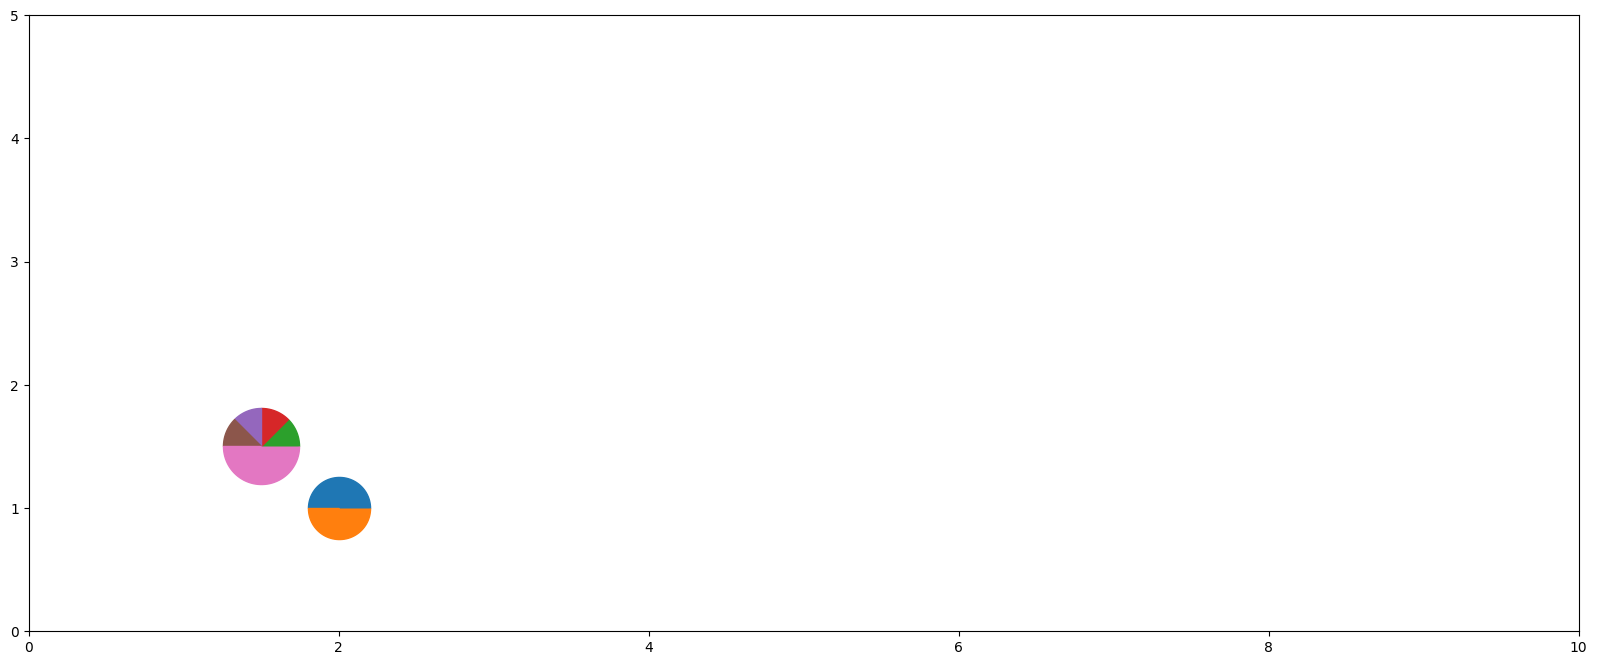

In [85]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(20,8))
draw_pie([2,2], 2, 1, 2000, ax=ax)
draw_pie([1,1,1,1,4], 1.5,1.5, 3000, ax=ax)
plt.xlim(0,10)
plt.ylim(0, 5)
plt.show()

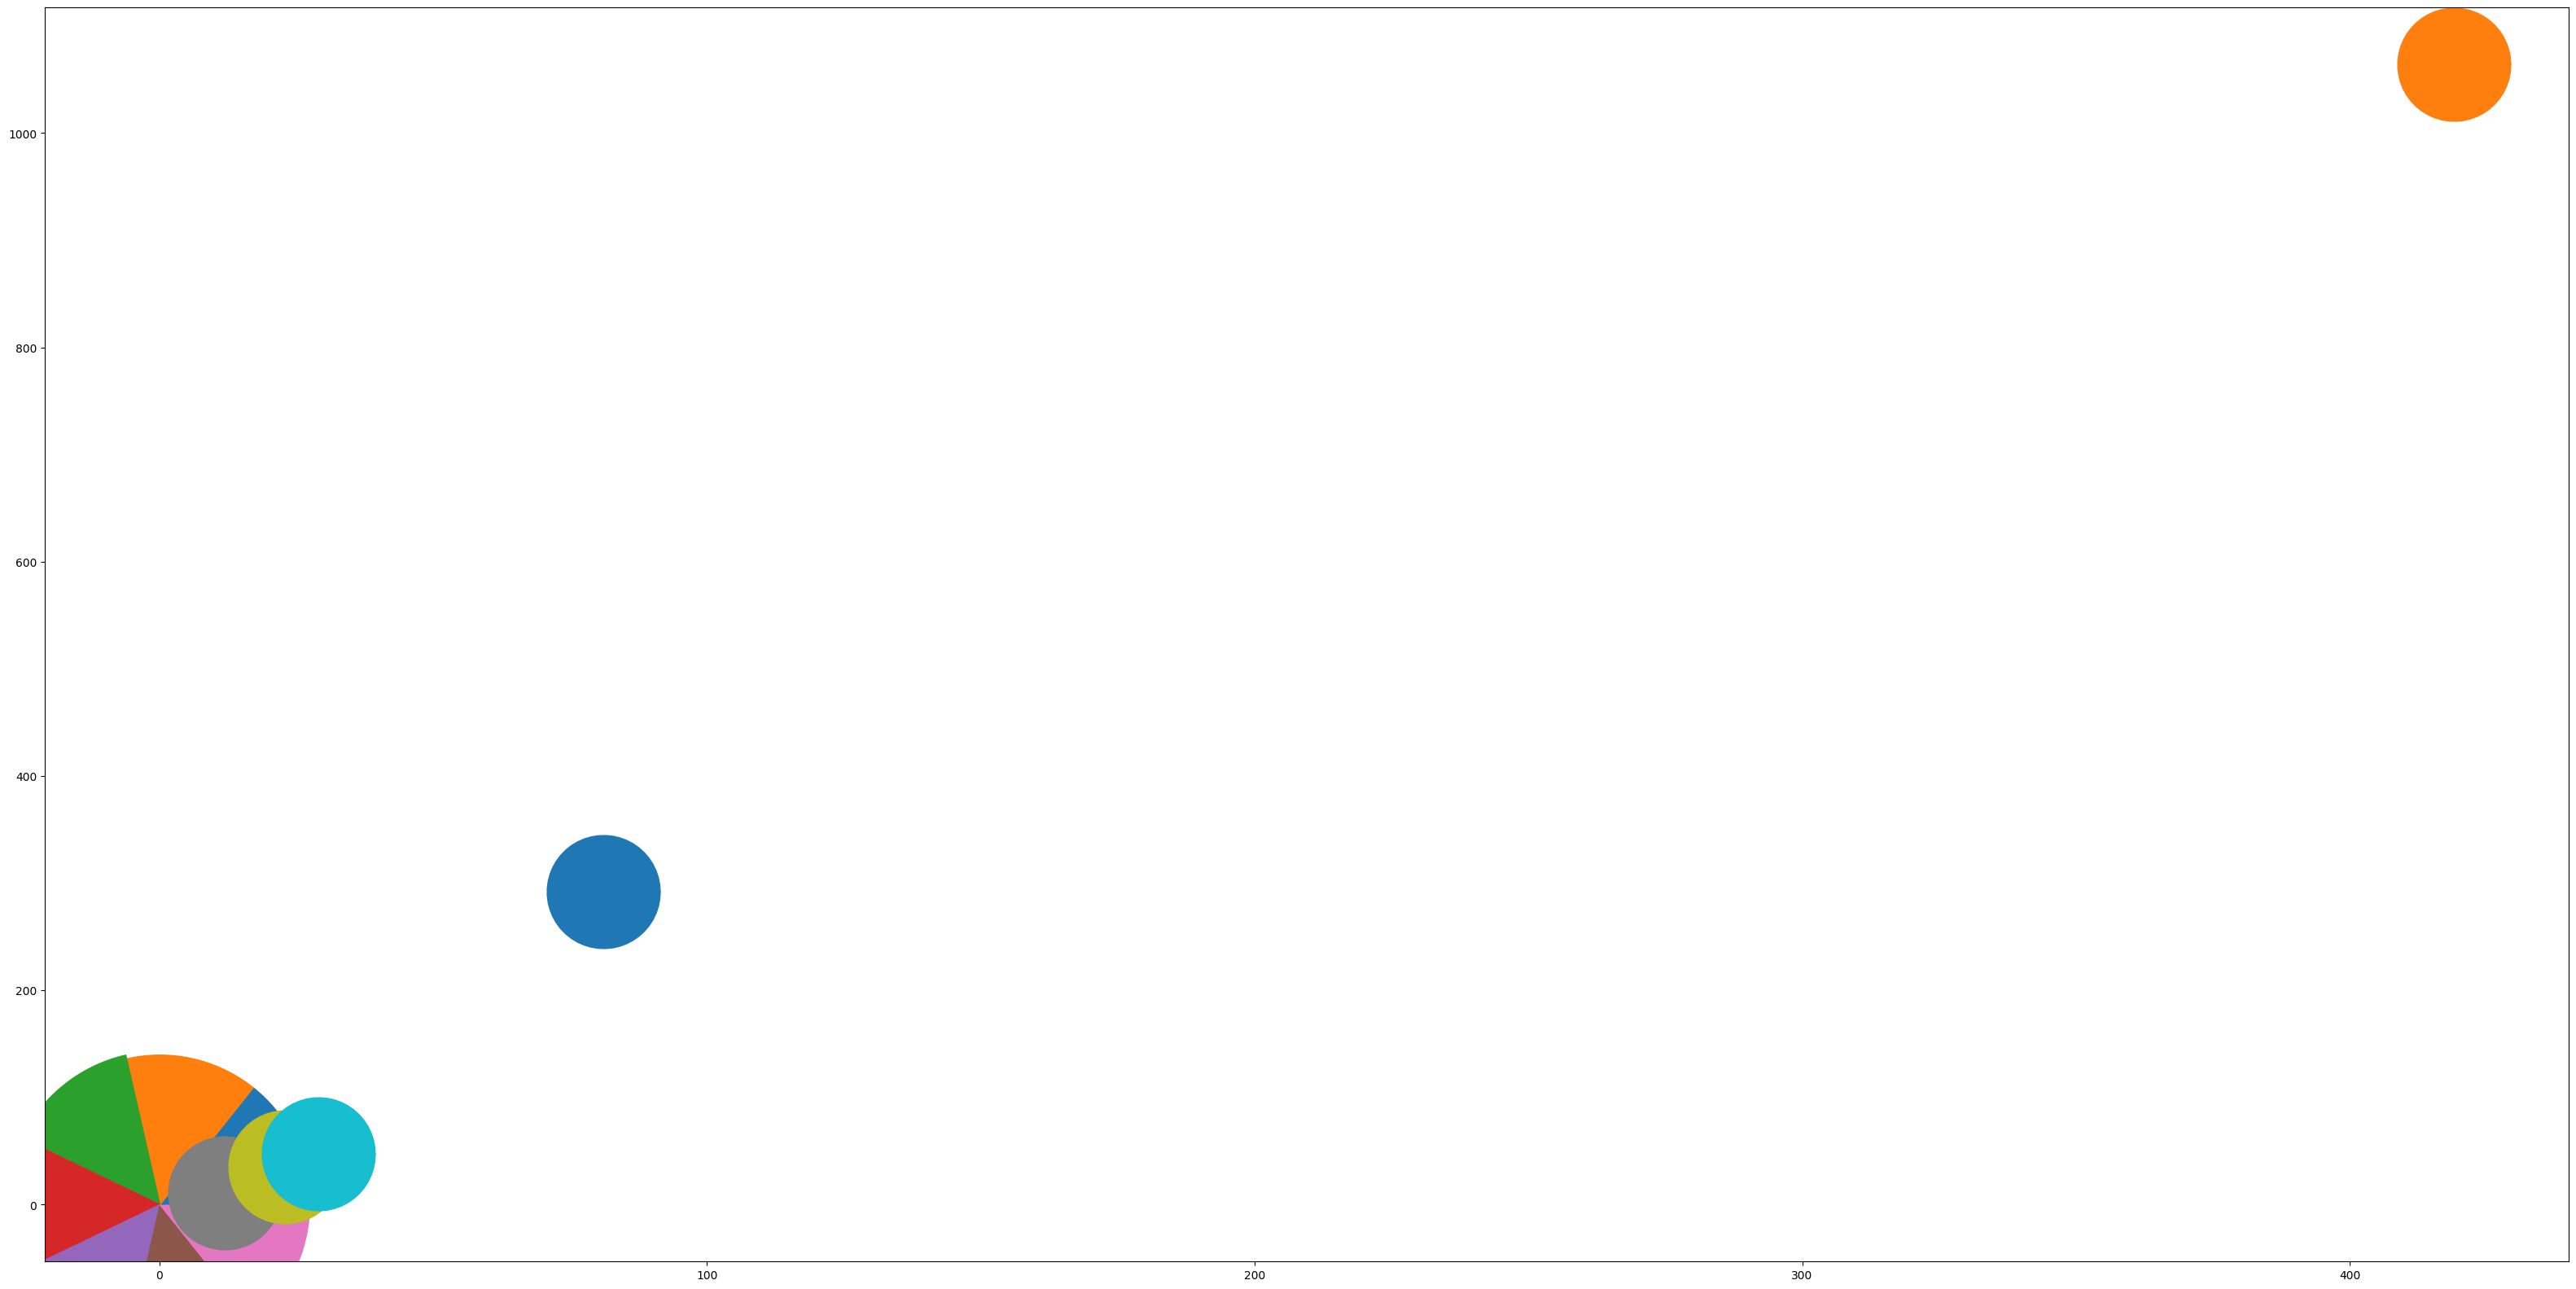

In [86]:
fig, ax = plt.subplots(figsize=(40,20))
for (x,y), d in not_supported_feature_impact_df.groupby(['Total Number Assertions','MOA Total Sum Impact Score']):
    dist = d['Category'].value_counts()
    draw_pie(dist, x, y, 10000*len(d), ax=ax)
plt.show()

In [87]:
not_supported_variant_impact_df = pd.read_csv("../not_supported_variant_impact_df.csv", sep=",")

In [88]:
merged_not_supported_impact_df = pd.merge(not_supported_feature_impact_df, not_supported_variant_impact_df, on='Category')
merged_not_supported_impact_df

,Category,MOA Total Sum Impact Score,Average Impact Score per Feature,Average Impact Score per Assertion,Total Number Assertions,Total Number Features,CIVIC Total Sum Impact Score,Average Impact Score per Variant,Average Impact Score per Evidence Item,Total Number Evidence Items,% Accepted Evidence Items,Total Number Variants
0,Expression,11,1.000000,1.000000,12,11,3618.00,9.397403,7.681529,618,55.34%,291
1,Epigenetic Modification,0,0.000000,0.000000,0,0,285.50,0.741558,0.606157,24,91.67%,15
2,Fusion,0,0.000000,0.000000,0,0,6600.75,17.144805,14.014331,1239,59.48%,308
3,Protein Consequence,1064,6.295858,6.295858,419,169,2683.75,6.970779,5.697983,301,63.46%,128
4,Gene Function,0,0.000000,0.000000,0,0,1805.50,4.689610,3.833333,348,44.25%,90
5,Rearrangements,292,7.684211,7.684211,81,38,653.00,1.696104,1.386412,136,38.97%,52
6,Copy Number,47,2.764706,2.764706,29,17,225.00,0.584416,0.477707,64,42.19%,34
7,Other,35,3.888889,3.888889,23,9,673.50,1.749351,1.429936,162,37.04%,93
8,Genotypes Easy,0,0.000000,0.000000,0,0,195.00,0.506494,0.414013,23,56.52%,11
9,Genotypes Compound,0,0.000000,0.000000,0,0,117.50,0.305195,0.249469,7,57.14%,6


In [89]:
merged_not_supported_impact_df['Sum Evidence Items'] = merged_not_supported_impact_df['Total Number Evidence Items']+merged_not_supported_impact_df['Total Number Assertions']
merged_not_supported_impact_df

,Category,MOA Total Sum Impact Score,Average Impact Score per Feature,Average Impact Score per Assertion,Total Number Assertions,Total Number Features,CIVIC Total Sum Impact Score,Average Impact Score per Variant,Average Impact Score per Evidence Item,Total Number Evidence Items,% Accepted Evidence Items,Total Number Variants,Sum Evidence Items
0,Expression,11,1.000000,1.000000,12,11,3618.00,9.397403,7.681529,618,55.34%,291,630
1,Epigenetic Modification,0,0.000000,0.000000,0,0,285.50,0.741558,0.606157,24,91.67%,15,24
2,Fusion,0,0.000000,0.000000,0,0,6600.75,17.144805,14.014331,1239,59.48%,308,1239
3,Protein Consequence,1064,6.295858,6.295858,419,169,2683.75,6.970779,5.697983,301,63.46%,128,720
4,Gene Function,0,0.000000,0.000000,0,0,1805.50,4.689610,3.833333,348,44.25%,90,348
5,Rearrangements,292,7.684211,7.684211,81,38,653.00,1.696104,1.386412,136,38.97%,52,217
6,Copy Number,47,2.764706,2.764706,29,17,225.00,0.584416,0.477707,64,42.19%,34,93
7,Other,35,3.888889,3.888889,23,9,673.50,1.749351,1.429936,162,37.04%,93,185
8,Genotypes Easy,0,0.000000,0.000000,0,0,195.00,0.506494,0.414013,23,56.52%,11,23
9,Genotypes Compound,0,0.000000,0.000000,0,0,117.50,0.305195,0.249469,7,57.14%,6,7


In [90]:
merged_not_supported_impact_df['Sum Variants'] = merged_not_supported_impact_df['Total Number Variants']+merged_not_supported_impact_df['Total Number Features']
merged_not_supported_impact_df

,Category,MOA Total Sum Impact Score,Average Impact Score per Feature,Average Impact Score per Assertion,Total Number Assertions,Total Number Features,CIVIC Total Sum Impact Score,Average Impact Score per Variant,Average Impact Score per Evidence Item,Total Number Evidence Items,% Accepted Evidence Items,Total Number Variants,Sum Evidence Items,Sum Variants
0,Expression,11,1.000000,1.000000,12,11,3618.00,9.397403,7.681529,618,55.34%,291,630,302
1,Epigenetic Modification,0,0.000000,0.000000,0,0,285.50,0.741558,0.606157,24,91.67%,15,24,15
2,Fusion,0,0.000000,0.000000,0,0,6600.75,17.144805,14.014331,1239,59.48%,308,1239,308
3,Protein Consequence,1064,6.295858,6.295858,419,169,2683.75,6.970779,5.697983,301,63.46%,128,720,297
4,Gene Function,0,0.000000,0.000000,0,0,1805.50,4.689610,3.833333,348,44.25%,90,348,90
5,Rearrangements,292,7.684211,7.684211,81,38,653.00,1.696104,1.386412,136,38.97%,52,217,90
6,Copy Number,47,2.764706,2.764706,29,17,225.00,0.584416,0.477707,64,42.19%,34,93,51
7,Other,35,3.888889,3.888889,23,9,673.50,1.749351,1.429936,162,37.04%,93,185,102
8,Genotypes Easy,0,0.000000,0.000000,0,0,195.00,0.506494,0.414013,23,56.52%,11,23,11
9,Genotypes Compound,0,0.000000,0.000000,0,0,117.50,0.305195,0.249469,7,57.14%,6,7,6


In [91]:
merged_not_supported_impact_df['Sum Impact Score'] = merged_not_supported_impact_df['CIVIC Total Sum Impact Score']+merged_not_supported_impact_df['MOA Total Sum Impact Score']
merged_not_supported_impact_df

,Category,MOA Total Sum Impact Score,Average Impact Score per Feature,Average Impact Score per Assertion,Total Number Assertions,Total Number Features,CIVIC Total Sum Impact Score,Average Impact Score per Variant,Average Impact Score per Evidence Item,Total Number Evidence Items,% Accepted Evidence Items,Total Number Variants,Sum Evidence Items,Sum Variants,Sum Impact Score
0,Expression,11,1.000000,1.000000,12,11,3618.00,9.397403,7.681529,618,55.34%,291,630,302,3629.00
1,Epigenetic Modification,0,0.000000,0.000000,0,0,285.50,0.741558,0.606157,24,91.67%,15,24,15,285.50
2,Fusion,0,0.000000,0.000000,0,0,6600.75,17.144805,14.014331,1239,59.48%,308,1239,308,6600.75
3,Protein Consequence,1064,6.295858,6.295858,419,169,2683.75,6.970779,5.697983,301,63.46%,128,720,297,3747.75
4,Gene Function,0,0.000000,0.000000,0,0,1805.50,4.689610,3.833333,348,44.25%,90,348,90,1805.50
5,Rearrangements,292,7.684211,7.684211,81,38,653.00,1.696104,1.386412,136,38.97%,52,217,90,945.00
6,Copy Number,47,2.764706,2.764706,29,17,225.00,0.584416,0.477707,64,42.19%,34,93,51,272.00
7,Other,35,3.888889,3.888889,23,9,673.50,1.749351,1.429936,162,37.04%,93,185,102,708.50
8,Genotypes Easy,0,0.000000,0.000000,0,0,195.00,0.506494,0.414013,23,56.52%,11,23,11,195.00
9,Genotypes Compound,0,0.000000,0.000000,0,0,117.50,0.305195,0.249469,7,57.14%,6,7,6,117.50


In [92]:
merged_not_supported_impact_df['Ratio of MOA Features to MOA+CIVIC per Category'] = merged_not_supported_impact_df['Total Number Features']/(merged_not_supported_impact_df['Total Number Features']+merged_not_supported_impact_df['Total Number Variants'])
merged_not_supported_impact_df

,Category,MOA Total Sum Impact Score,Average Impact Score per Feature,Average Impact Score per Assertion,Total Number Assertions,Total Number Features,CIVIC Total Sum Impact Score,Average Impact Score per Variant,Average Impact Score per Evidence Item,Total Number Evidence Items,% Accepted Evidence Items,Total Number Variants,Sum Evidence Items,Sum Variants,Sum Impact Score,Ratio of MOA Features to MOA+CIVIC per Category
0,Expression,11,1.000000,1.000000,12,11,3618.00,9.397403,7.681529,618,55.34%,291,630,302,3629.00,0.036424
1,Epigenetic Modification,0,0.000000,0.000000,0,0,285.50,0.741558,0.606157,24,91.67%,15,24,15,285.50,0.000000
2,Fusion,0,0.000000,0.000000,0,0,6600.75,17.144805,14.014331,1239,59.48%,308,1239,308,6600.75,0.000000
3,Protein Consequence,1064,6.295858,6.295858,419,169,2683.75,6.970779,5.697983,301,63.46%,128,720,297,3747.75,0.569024
4,Gene Function,0,0.000000,0.000000,0,0,1805.50,4.689610,3.833333,348,44.25%,90,348,90,1805.50,0.000000
5,Rearrangements,292,7.684211,7.684211,81,38,653.00,1.696104,1.386412,136,38.97%,52,217,90,945.00,0.422222
6,Copy Number,47,2.764706,2.764706,29,17,225.00,0.584416,0.477707,64,42.19%,34,93,51,272.00,0.333333
7,Other,35,3.888889,3.888889,23,9,673.50,1.749351,1.429936,162,37.04%,93,185,102,708.50,0.088235
8,Genotypes Easy,0,0.000000,0.000000,0,0,195.00,0.506494,0.414013,23,56.52%,11,23,11,195.00,0.000000
9,Genotypes Compound,0,0.000000,0.000000,0,0,117.50,0.305195,0.249469,7,57.14%,6,7,6,117.50,0.000000


In [93]:
import numpy as np
from numpy import pi, sin, cos
import plotly.graph_objects as go

def degree2rad(degrees):
    return degrees*pi/180
def disk_part(center=[0,0], radius=1, start_angle=0, end_angle=90, n=50, seg=True):
    sta = degree2rad(start_angle)
    ea = degree2rad(end_angle)
    t = np.linspace(sta, ea, n)
    x = center[0] + radius*cos(t)
    y = center[1] +radius*sin(t)
    path = f"M {x[0]},{y[0]}"
    for xc, yc in zip(x[1:], y[1:]):
        path += f" L{xc},{yc}"
    if seg: #segment
        return path + " Z"
    else: #disk sector
        return path + f" L{center[0]},{center[1]} Z" #sector

In [94]:
layout = go.Layout(
    title="Title",
    xaxis=dict(
        title="Number of Evidence Items"
    ),
    yaxis=dict(
        title="Impact Score"
    ) ) 

In [97]:
fig.write_html("merged_not_supported_impact_df_scatterpieplot.html")

In [98]:
merged_not_supported_impact_df.head()

,Category,MOA Total Sum Impact Score,Average Impact Score per Feature,Average Impact Score per Assertion,Total Number Assertions,Total Number Features,CIVIC Total Sum Impact Score,Average Impact Score per Variant,Average Impact Score per Evidence Item,Total Number Evidence Items,% Accepted Evidence Items,Total Number Variants,Sum Evidence Items,Sum Variants,Sum Impact Score,Ratio of MOA Features to MOA+CIVIC per Category
0,Expression,11,1.000000,1.000000,12,11,3618.00,9.397403,7.681529,618,55.34%,291,630,302,3629.00,0.036424
1,Epigenetic Modification,0,0.000000,0.000000,0,0,285.50,0.741558,0.606157,24,91.67%,15,24,15,285.50,0.000000
2,Fusion,0,0.000000,0.000000,0,0,6600.75,17.144805,14.014331,1239,59.48%,308,1239,308,6600.75,0.000000
3,Protein Consequence,1064,6.295858,6.295858,419,169,2683.75,6.970779,5.697983,301,63.46%,128,720,297,3747.75,0.569024
4,Gene Function,0,0.000000,0.000000,0,0,1805.50,4.689610,3.833333,348,44.25%,90,348,90,1805.50,0.000000


In [99]:
ratio_list = merged_not_supported_impact_df["Ratio of MOA Features to MOA+CIVIC per Category"].to_numpy()
ratio_list

array([0.03642384, 0.        , 0.        , 0.56902357, 0.        ,
       0.42222222, 0.33333333, 0.08823529, 0.        , 0.        ,
       0.        , 0.        ])

In [100]:
moa_civic_evidence_sum_list = merged_not_supported_impact_df["Sum Evidence Items"].to_numpy()
moa_civic_evidence_sum_list

array([ 630,   24, 1239,  720,  348,  217,   93,  185,   23,    7,  976,
        471])

In [101]:
moa_civic_variant_sum_list = merged_not_supported_impact_df["Sum Variants"].to_numpy()
moa_civic_variant_sum_list

array([302,  15, 308, 297,  90,  90,  51, 102,  11,   6, 209, 385])

In [102]:
moa_civic_impact_score_list = merged_not_supported_impact_df["Sum Impact Score"].to_numpy()
moa_civic_impact_score_list

array([3629.  ,  285.5 , 6600.75, 3747.75, 1805.5 ,  945.  ,  272.  ,
        708.5 ,  195.  ,  117.5 , 8353.5 ,  356.5 ])

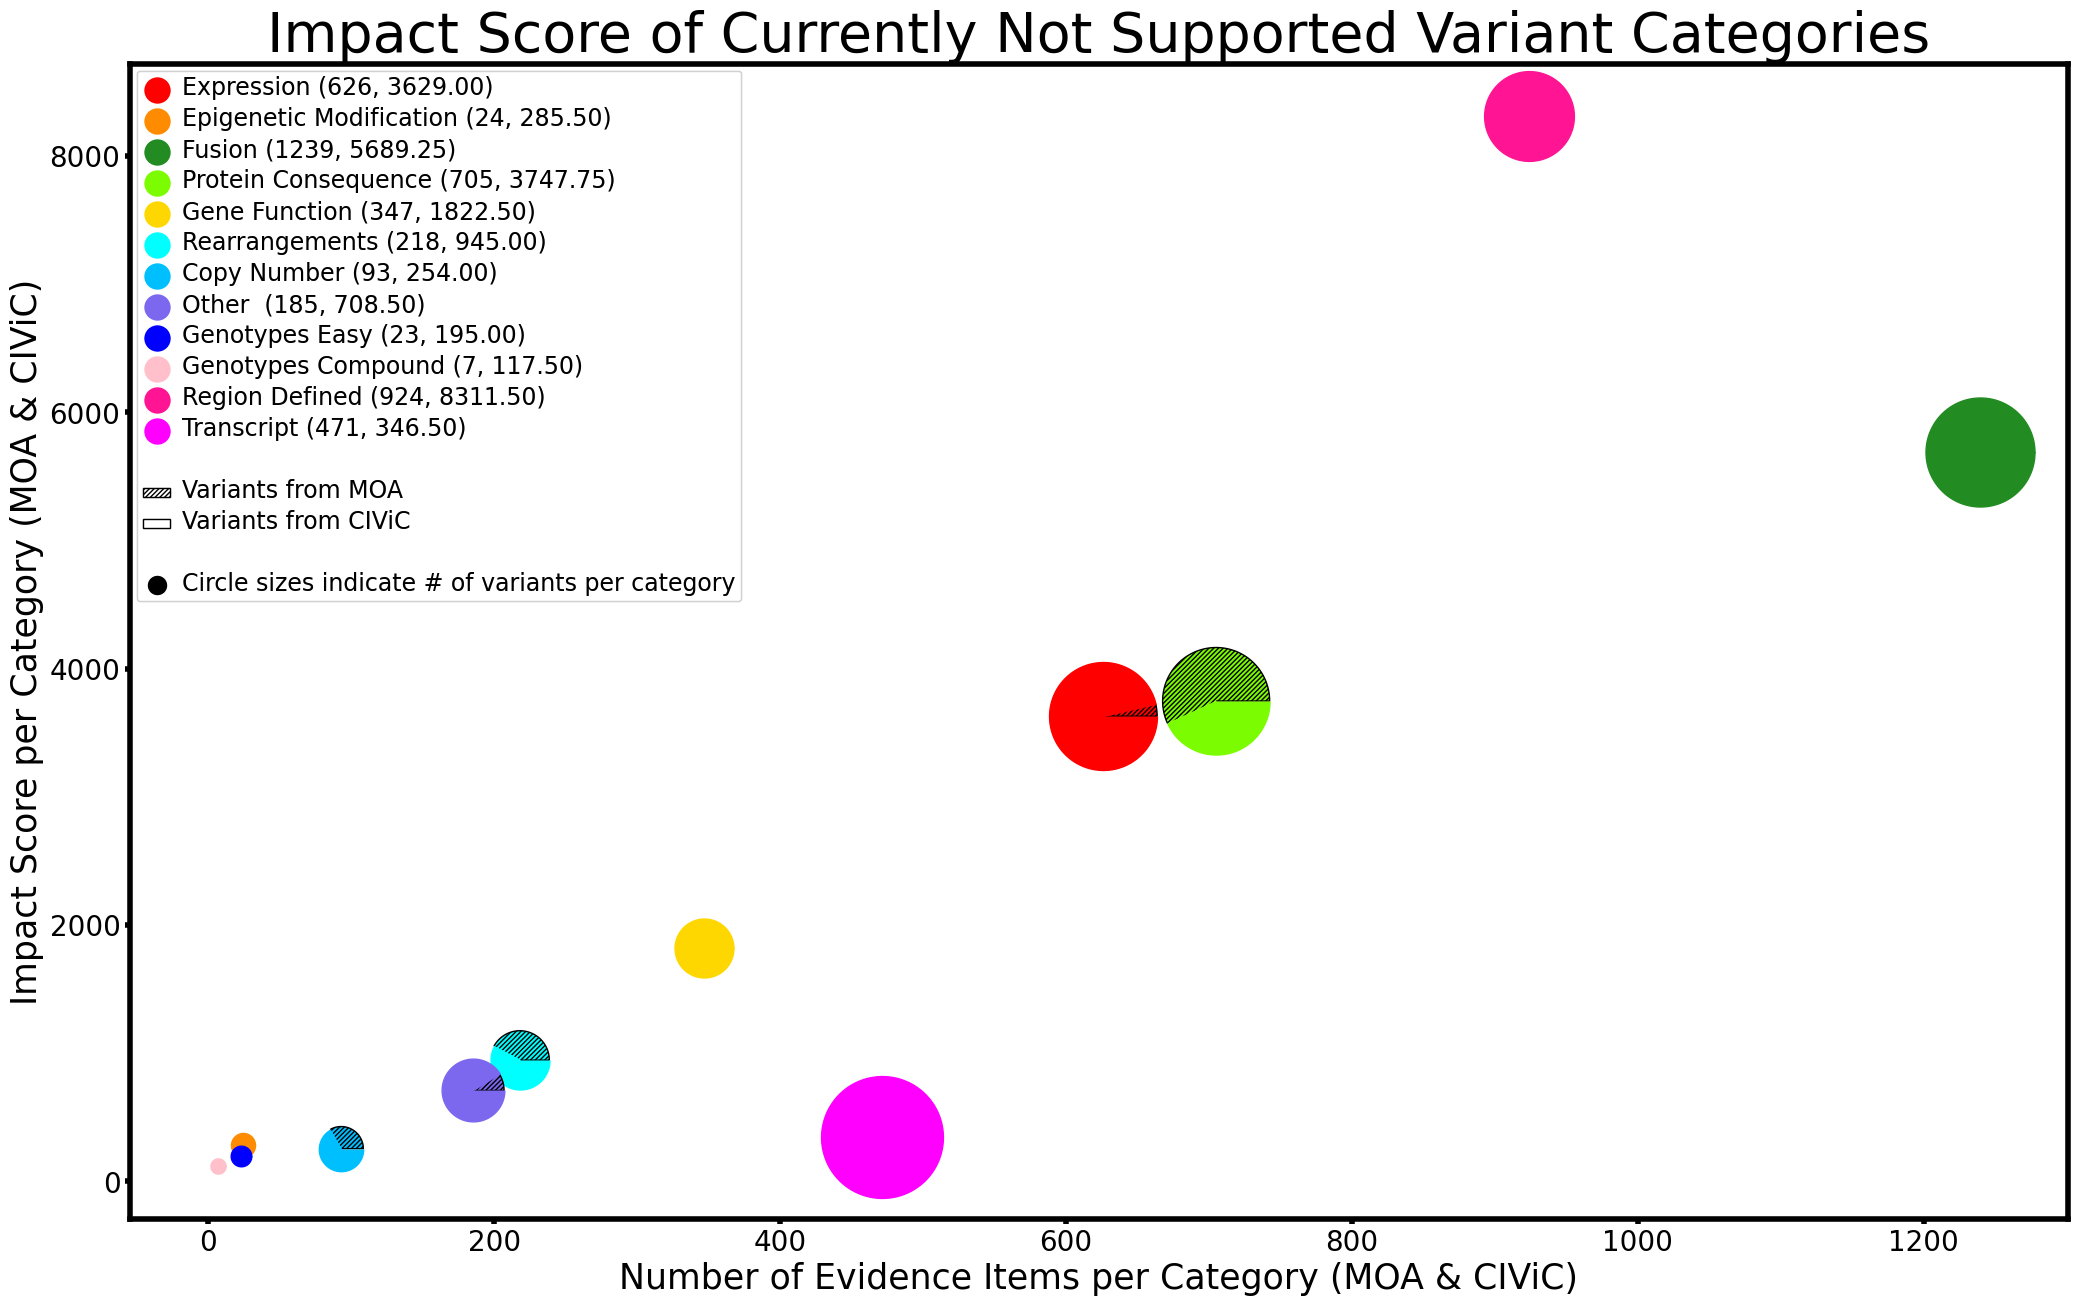

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
from matplotlib.lines import Line2D
import base64
from io import BytesIO
import mpld3
from matplotlib.pyplot import figure
from matplotlib.hatch import Circles
from matplotlib.widgets import TextBox
# first define the ratios
r1= ratio_list[0]  
r2=ratio_list[1]
r3=ratio_list[2] 
r4= ratio_list[3]  
r5=ratio_list[4]
r6=ratio_list[5]
r7=ratio_list[6]
r8=ratio_list[7]
r9=ratio_list[8]
r10=ratio_list[9] 
r11= ratio_list[10] 
r12=ratio_list[11]

# define some sizes of the scatter marker
size1=moa_civic_variant_sum_list[0]*20  
size2=moa_civic_variant_sum_list[1]*20 
size3=moa_civic_variant_sum_list[2]*20
size4=moa_civic_variant_sum_list[3]*20 
size5=moa_civic_variant_sum_list[4]*20 
size6=moa_civic_variant_sum_list[5]*20 
size7=moa_civic_variant_sum_list[6]*20 
size8=moa_civic_variant_sum_list[7]*20 
size9=moa_civic_variant_sum_list[8]*20 
size10=moa_civic_variant_sum_list[9]*20  
size11=moa_civic_variant_sum_list[10]*20  
size12=moa_civic_variant_sum_list[11]*20 

# calculate the points of the first pie marker
#
# these are just the origin (0,0) +
# some points on a circle cos,sin
x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 100)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 100)).tolist()
xy1a = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(2 * np.pi * r1, 2 * np.pi, 100)).tolist()
y = [0] + np.sin(np.linspace(2 * np.pi * r1, 2 * np.pi, 100)).tolist()
xy1b = np.column_stack([x, y])

# x = [0] + np.cos(np.linspace(0, 2 * np.pi * r2, 10)).tolist()
# y = [0] + np.sin(np.linspace(0, 2 * np.pi * r2, 10)).tolist()
# xy2a = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(2 * np.pi * r2, 2 * np.pi, 100)).tolist()
y = [0] + np.sin(np.linspace(2 * np.pi * r2, 2 * np.pi, 100)).tolist()
xy2b = np.column_stack([x, y])

# x = [0] + np.cos(np.linspace(0, 2 * np.pi * r3, 10)).tolist()
# y = [0] + np.sin(np.linspace(0, 2 * np.pi * r3, 10)).tolist()
# xy3a = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(2 * np.pi * r3, 2 * np.pi, 100)).tolist()
y = [0] + np.sin(np.linspace(2 * np.pi * r3, 2 * np.pi, 100)).tolist()
xy3b = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r4, 100)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r4, 100)).tolist()
xy4a = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(2 * np.pi * r4, 2 * np.pi, 100)).tolist()
y = [0] + np.sin(np.linspace(2 * np.pi * r4, 2 * np.pi, 100)).tolist()
xy4b = np.column_stack([x, y])

# x = [0] + np.cos(np.linspace(0, 2 * np.pi * r5, 10)).tolist()
# y = [0] + np.sin(np.linspace(0, 2 * np.pi * r5, 10)).tolist()
# xy5a = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(2 * np.pi * r5, 2 * np.pi, 100)).tolist()
y = [0] + np.sin(np.linspace(2 * np.pi * r5, 2 * np.pi, 100)).tolist()
xy5b = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r6, 100)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r6, 100)).tolist()
xy6a = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(2 * np.pi * r6, 2 * np.pi, 100)).tolist()
y = [0] + np.sin(np.linspace(2 * np.pi * r6, 2 * np.pi, 100)).tolist()
xy6b = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r7, 100)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r7, 100)).tolist()
xy7a = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(2 * np.pi * r7, 2 * np.pi, 100)).tolist()
y = [0] + np.sin(np.linspace(2 * np.pi * r7, 2 * np.pi, 100)).tolist()
xy7b = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(0, 2 * np.pi * r8, 100)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r8, 100)).tolist()
xy8a = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(2 * np.pi * r8, 2 * np.pi, 100)).tolist()
y = [0] + np.sin(np.linspace(2 * np.pi * r8, 2 * np.pi, 100)).tolist()
xy8b = np.column_stack([x, y])

# x = [0] + np.cos(np.linspace(0, 2 * np.pi * r9, 10)).tolist()
# y = [0] + np.sin(np.linspace(0, 2 * np.pi * r9, 10)).tolist()
# xy9a = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(2 * np.pi * r9, 2 * np.pi, 100)).tolist()
y = [0] + np.sin(np.linspace(2 * np.pi * r9, 2 * np.pi, 100)).tolist()
xy9b = np.column_stack([x, y])

# x = [0] + np.cos(np.linspace(0, 2 * np.pi * r10, 10)).tolist()
# y = [0] + np.sin(np.linspace(0, 2 * np.pi * r10, 10)).tolist()
# xy10a = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(2 * np.pi * r10, 2 * np.pi, 100)).tolist()
y = [0] + np.sin(np.linspace(2 * np.pi * r10, 2 * np.pi, 100)).tolist()
xy10b = np.column_stack([x, y])

# x = [0] + np.cos(np.linspace(0, 2 * np.pi * r11, 10)).tolist()
# y = [0] + np.sin(np.linspace(0, 2 * np.pi * r11, 10)).tolist()
# xy11a = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(2 * np.pi * r11, 2 * np.pi, 100)).tolist()
y = [0] + np.sin(np.linspace(2 * np.pi * r11, 2 * np.pi, 100)).tolist()
xy11b = np.column_stack([x, y])

# x = [0] + np.cos(np.linspace(0, 2 * np.pi * r12, 10)).tolist()
# y = [0] + np.sin(np.linspace(0, 2 * np.pi * r12, 10)).tolist()
# xy12a = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(2 * np.pi * r12, 2 * np.pi, 100)).tolist()
y = [0] + np.sin(np.linspace(2 * np.pi * r12, 2 * np.pi, 100)).tolist()
xy12b = np.column_stack([x, y])


fig5, ax = plt.subplots(figsize=(25, 15))

ax.scatter(moa_civic_evidence_sum_list[0],moa_civic_impact_score_list[0], marker=xy1a,
           s=size1, facecolor='red', edgecolors='black', hatch='///////' )
ax.scatter(moa_civic_evidence_sum_list[0],moa_civic_impact_score_list[0], marker=xy1b,
           s=size1, facecolor='red')

# ax.scatter(moa_civic_evidence_sum_list[1],moa_civic_impact_score_list[1], marker=xy2a,
#            s=size2, facecolor='blue')
ax.scatter(moa_civic_evidence_sum_list[1],moa_civic_impact_score_list[1], marker=xy2b,
           s=size2, facecolor='darkorange')

# ax.scatter(moa_civic_evidence_sum_list[2],moa_civic_impact_score_list[2], marker=xy3a,
#            s=size3, facecolor='blue')
ax.scatter(moa_civic_evidence_sum_list[2],moa_civic_impact_score_list[2], marker=xy3b,
           s=size3, facecolor='forestgreen')

ax.scatter(moa_civic_evidence_sum_list[3],moa_civic_impact_score_list[3], marker=xy4a,
           s=size4, facecolor='lawngreen', edgecolors='black', hatch='///////')
ax.scatter(moa_civic_evidence_sum_list[3],moa_civic_impact_score_list[3], marker=xy4b,
           s=size4, facecolor='lawngreen')

# ax.scatter(moa_civic_evidence_sum_list[4],moa_civic_impact_score_list[4], marker=xy5a,
#            s=size5, facecolor='blue')
ax.scatter(moa_civic_evidence_sum_list[4],moa_civic_impact_score_list[4], marker=xy5b,
           s=size5, facecolor='gold')

ax.scatter(moa_civic_evidence_sum_list[5],moa_civic_impact_score_list[5], marker=xy6a,
           s=size6, facecolor='cyan', edgecolors='black', hatch='///////')
ax.scatter(moa_civic_evidence_sum_list[5],moa_civic_impact_score_list[5], marker=xy6b,
           s=size6, facecolor='cyan')

ax.scatter(moa_civic_evidence_sum_list[6],moa_civic_impact_score_list[6], marker=xy7a,
           s=size7, facecolor='deepskyblue' , edgecolors='black', hatch='///////')
ax.scatter(moa_civic_evidence_sum_list[6],moa_civic_impact_score_list[6], marker=xy7b,
           s=size7, facecolor='deepskyblue')

ax.scatter(moa_civic_evidence_sum_list[7],moa_civic_impact_score_list[7], marker=xy8a,
           s=size8, facecolor='mediumslateblue', edgecolors='black', hatch='///////' )
ax.scatter(moa_civic_evidence_sum_list[7],moa_civic_impact_score_list[7], marker=xy8b,
           s=size8, facecolor='mediumslateblue')

# ax.scatter(moa_civic_evidence_sum_list[8],moa_civic_impact_score_list[8], marker=xy9a,
#            s=size9, facecolor='blue')
ax.scatter(moa_civic_evidence_sum_list[8],moa_civic_impact_score_list[8], marker=xy9b,
           s=size9, facecolor='blue')

# ax.scatter(moa_civic_evidence_sum_list[9],moa_civic_impact_score_list[9], marker=xy10a,
#            s=size10, facecolor='blue')
ax.scatter(moa_civic_evidence_sum_list[9],moa_civic_impact_score_list[9], marker=xy10b,
           s=size10, facecolor='pink')

# ax.scatter(moa_civic_evidence_sum_list[10],moa_civic_impact_score_list[10], marker=xy11a,
#            s=size11, facecolor='blue')
ax.scatter(moa_civic_evidence_sum_list[10],moa_civic_impact_score_list[10], marker=xy11b,
           s=size11, facecolor='deeppink')

# ax.scatter(moa_civic_evidence_sum_list[11],moa_civic_impact_score_list[11], marker=xy12a,
#            s=size12, facecolor='blue')
ax.scatter(moa_civic_evidence_sum_list[11],moa_civic_impact_score_list[11], marker=xy12b,
           s=size12, facecolor='fuchsia')


legend_elements = [Line2D([0], [0], marker='o', color='w', label='Expression (626, 3629.00)',
                          markerfacecolor='red', markersize=20),
                   Line2D([0], [0], marker='o', color='w', label='Epigenetic Modification (24, 285.50)',
                          markerfacecolor='darkorange', markersize=20),
                   Line2D([0], [0], marker='o', color='w', label='Fusion (1239, 5689.25)',
                          markerfacecolor='forestgreen', markersize=20),       
                   Line2D([0], [0], marker='o', color='w', label='Protein Consequence (705, 3747.75)',
                          markerfacecolor='lawngreen', markersize=20),       
                   Line2D([0], [0], marker='o', color='w', label='Gene Function (347, 1822.50)',
                          markerfacecolor='gold', markersize=20),       
                   Line2D([0], [0], marker='o', color='w', label='Rearrangements (218, 945.00)',
                          markerfacecolor='cyan', markersize=20),       
                   Line2D([0], [0], marker='o', color='w', label='Copy Number (93, 254.00)',
                          markerfacecolor='deepskyblue', markersize=20),
                   Line2D([0], [0], marker='o', color='w', label='Other  (185, 708.50)',
                          markerfacecolor='mediumslateblue', markersize=20),
                   Line2D([0], [0], marker='o', color='w', label='Genotypes Easy (23, 195.00)',
                          markerfacecolor='blue', markersize=20),       
                   Line2D([0], [0], marker='o', color='w', label='Genotypes Compound (7, 117.50)',
                          markerfacecolor='pink', markersize=20),       
                   Line2D([0], [0], marker='o', color='w', label='Region Defined (924, 8311.50)',
                          markerfacecolor='deeppink', markersize=20),       
                   Line2D([0], [0], marker='o', color='w', label='Transcript (471, 346.50)',
                          markerfacecolor='fuchsia', markersize=20),
                   Line2D([0], [0], color='w',
                          markerfacecolor='white'),       
                   mpatches.Circle(xy=(0,0), radius=1, edgecolor="black", facecolor= "white", hatch='///////', label='Variants from MOA'), 
                   mpatches.Circle(xy=(0,0), radius=1, edgecolor="black", facecolor= "white", label='Variants from CIViC'),
                   Line2D([0], [0], color='w',
                          markerfacecolor='white'),
                   Line2D([0], [0], marker='o', color='w', label='Circle sizes indicate # of variants per category',
                          markerfacecolor='black', markersize=15)]

# Create the figure
first_legend = ax.legend(handles=legend_elements, loc='upper left')
first_legend._legend_box.align = "left"
ax.add_artist(first_legend)
ax.set_xlabel('Number of Evidence Items per Category (MOA & CIViC)', fontsize= 25)
ax.set_ylabel('Impact Score per Category (MOA & CIViC)', fontsize= 25)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)
ax.tick_params(width=4)
plt.title("Impact Score of Currently Not Supported Variant Categories", fontsize=40)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.setp(plt.gca().get_legend().get_texts(), fontsize='17')

plt.savefig('myfig2.jpeg', dpi=1000)

plt.show()